In [1]:
import feather
import scipy as sp
import numpy as np
import pandas as pd
import lightgbm as lgb

from collections import Counter
from functools import partial
from math import sqrt
from scipy.stats import rankdata

from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.metrics import confusion_matrix as sk_cmatrix
from sklearn.model_selection import StratifiedKFold, GroupKFold

import matplotlib.pyplot as plt
import seaborn as sns

def get_score(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def get_y():
    return pd.read_csv('../input/petfinder-adoption-prediction/train/train.csv', usecols=[target]).values.flatten()
    
def run_model(X_train, y_train, X_valid, y_valid,
            categorical_features, numerical_features,
            predictors, maxvalue_dict, fold_id):
    train = lgb.Dataset(X_train, y_train, 
                        categorical_feature=categorical_features, 
                        feature_name=predictors)
    valid = lgb.Dataset(X_valid, y_valid, 
                        categorical_feature=categorical_features, 
                        feature_name=predictors)
    evals_result = {}
    model = lgb.train(
        MODEL_PARAMS,
        train,
        valid_sets=[valid],
        valid_names=['valid'],
        evals_result=evals_result,
        **FIT_PARAMS
    )
    
    # validation score
    y_pred_valid = model.predict(X_valid)

    # feature importances
    importances = pd.DataFrame()
    importances['feature'] = predictors
    importances['gain'] = model.feature_importance(importance_type='gain')
    importances['split'] = model.feature_importance(importance_type='split')
    importances['fold'] = fold_id

    return y_pred_valid, importances
 
def plot_mean_feature_importances(feature_importances, max_num=50, importance_type='gain', path=None):
    mean_gain = feature_importances[[importance_type, 'feature']].groupby('feature').mean()
    feature_importances['mean_' + importance_type] = feature_importances['feature'].map(mean_gain[importance_type])

    if path is not None:
        data = feature_importances.sort_values('mean_'+importance_type, ascending=False).iloc[:max_num, :]
        plt.clf()
        plt.figure(figsize=(16, 8))
        sns.barplot(x=importance_type, y='feature', data=data)
        plt.tight_layout()
        plt.savefig(path)
    
    return feature_importances

def to_bins(x, borders):
    for i in range(len(borders)):
        if x <= borders[i]:
            return i
    return len(borders)

class OptimizedRounder_(object):
    def __init__(self):
        self.coef_ = 0

    def _loss(self, coef, X, y, idx):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        ll = -get_score(y, X_p)
        return ll

    def fit(self, X, y):
        coef = [1.5, 2.0, 2.5, 3.0]
        golden1 = 0.618
        golden2 = 1 - golden1
        ab_start = [(1, 2), (1.5, 2.5), (2, 3), (2.5, 3.5)]
        for it1 in range(10):
            for idx in range(4):
                # golden section search
                a, b = ab_start[idx]
                # calc losses
                coef[idx] = a
                la = self._loss(coef, X, y, idx)
                coef[idx] = b
                lb = self._loss(coef, X, y, idx)
                for it in range(20):
                    # choose value
                    if la > lb:
                        a = b - (b - a) * golden1
                        coef[idx] = a
                        la = self._loss(coef, X, y, idx)
                    else:
                        b = b - (b - a) * golden2
                        coef[idx] = b
                        lb = self._loss(coef, X, y, idx)
        self.coef_ = {'x': coef}

    def predict(self, X, coef):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        return X_p

    def coefficients(self):
        return self.coef_['x']
    
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _loss(self, coef, X, y, idx):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        ll = -get_score(y, X_p)
        return ll

    def fit(self, X, y):
        coef = [0.2, 0.4, 0.6, 0.8]
        golden1 = 0.618
        golden2 = 1 - golden1
        ab_start = [(0.01, 0.3), (0.15, 0.56), (0.35, 0.75), (0.6, 0.9)]
        for it1 in range(10):
            for idx in range(4):
                # golden section search
                a, b = ab_start[idx]
                # calc losses
                coef[idx] = a
                la = self._loss(coef, X, y, idx)
                coef[idx] = b
                lb = self._loss(coef, X, y, idx)
                for it in range(20):
                    # choose value
                    if la > lb:
                        a = b - (b - a) * golden1
                        coef[idx] = a
                        la = self._loss(coef, X, y, idx)
                    else:
                        b = b - (b - a) * golden2
                        coef[idx] = b
                        lb = self._loss(coef, X, y, idx)
        self.coef_ = {'x': coef}

    def predict(self, X, coef):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        return X_p

    def coefficients(self):
        return self.coef_['x']
    
class StratifiedGroupKFold():
    def __init__(self, n_splits=5):
        self.n_splits = n_splits
    
    def split(self, X, y=None, groups=None):
        fold = pd.DataFrame([X, y, groups]).T
        fold.columns = ['X', 'y', 'groups']
        fold['y'] = fold['y'].astype(int)
        g = fold.groupby('groups')['y'].agg('mean').reset_index()
        fold = fold.merge(g, how='left', on='groups', suffixes=('', '_mean'))
        fold['y_mean'] = fold['y_mean'].apply(np.round)
        fold['fold_id'] = 0
        for unique_y in fold['y_mean'].unique():
            mask = fold.y_mean==unique_y
            selected = fold[mask].reset_index(drop=True)
            cv = GroupKFold(n_splits=n_splits)
            for i, (train_index, valid_index) in enumerate(cv.split(range(len(selected)), y=None, groups=selected['groups'])):
                selected.loc[valid_index, 'fold_id'] = i
            fold.loc[mask, 'fold_id'] = selected['fold_id'].values
            
        for i in range(self.n_splits):
            indices = np.arange(len(fold))
            train_index = indices[fold['fold_id'] != i]
            valid_index = indices[fold['fold_id'] == i]
            yield train_index, valid_index
            
def merge(train, test, path, add_cols):
    df_ = feather.read_dataframe(path)
    add_cols += list(df_.columns)
    train = pd.concat((train, df_[:len_train]), axis=1)
    test = pd.concat((test, df_[len_train:].reset_index(drop=True)), axis=1)
    return train, test, add_cols

In [2]:
target = 'AdoptionSpeed'
len_train = 14993
len_test = 3948
    
    
# ===============
# Params
# ===============
seed = 777
n_splits = 5
np.random.seed(seed)

# feature engineering
n_components = 5
img_size = 256
batch_size = 256

# model
MODEL_PARAMS = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'num_leaves': 63,
    'subsample': 0.9,
    'subsample_freq': 1,
    #'colsample_bytree': 0.6,
    'max_depth': 9,
    'max_bin': 127,
    'reg_alpha': 0.11,
    'reg_lambda': 0.01,
    'min_child_weight': 0.2,
    'min_child_samples': 20,
    'min_gain_to_split': 0.02,
    'min_data_in_bin': 3,
    'bin_construct_sample_cnt': 5000,
    'cat_l2': 10,
    'verbose': -1,
    'nthread': 16,
    'seed': 777,
}
FIT_PARAMS = {
    'num_boost_round': 5000,
    'early_stopping_rounds': 100,
    'verbose_eval': 10000,
}

# define
maxvalue_dict = {}
categorical_features = [
     'Breed1',
     'Breed2',
     'Color1',
     'Color2',
     'Color3',
     'Dewormed',
     'FurLength',
     'Gender',
     'Health',
     'MaturitySize',
     'State',
     'Sterilized',
     'Type',
     'Vaccinated',
     'Type_main_breed',
     'BreedName_main_breed',
     'Type_second_breed',
     'BreedName_second_breed',
]
numerical_features = []
text_features = ['Name', 'Description']
remove = ['index', 'seq_text', 'PetID', 'Name', 'Description', 'RescuerID', 'StateName', 'annots_top_desc','sentiment_text', 
          'Description_Emb', 'Description_bow', 'annots_top_desc_pick', "BreedName_y", "BreedName_x"]

In [3]:
train = feather.read_dataframe('from_kernel/all_datav17.feather')
#df_ = feather.read_dataframe("from_kernel/all_data.feather")[['magnitude_mean', 'document_sum_magnitude_mean', 'score_mean', 'document_sum_score_mean']]
#train = pd.concat((train, df_), axis=1)
test = train[len_train:]
train = train[:len_train]
add_cols = []

4360


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1061]	valid's rmse: 1.01977


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1082]	valid's rmse: 1.06669


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1171]	valid's rmse: 1.0469


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[876]	valid's rmse: 1.03558


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[543]	valid's rmse: 1.04223
0.44653259871572715
CPU times: user 2h 33min 25s, sys: 9.21 s, total: 2h 33min 34s
Wall time: 10min 30s


<Figure size 432x288 with 0 Axes>

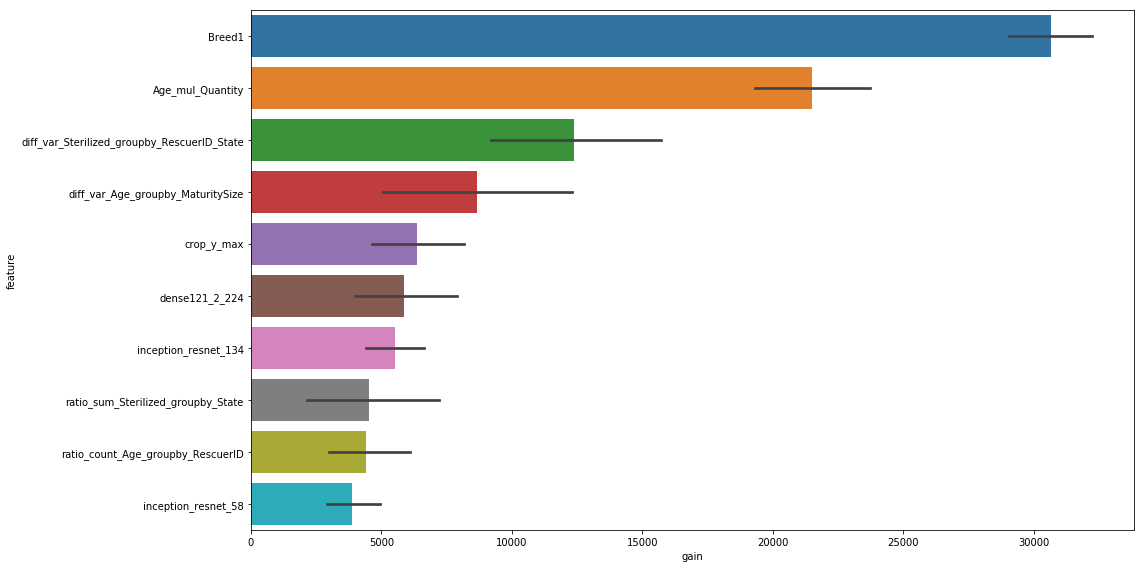

In [7]:
%%time
categorical_features = list(set(categorical_features) - set(remove))
predictors = list(set(list(np.load("from_kernel/common_colsv17.npy"))+list(np.load("from_kernel/t_colsv17.npy"))) - set([target] + remove))
predictors.remove("contain_dog")
predictors = predictors + ["desc_contain_dog"]
#predictors = [c for c in predictors if "dense" not in c]
#predictors = predictors + add_cols

categorical_features = [c for c in categorical_features if c in predictors]
print(len(predictors))
#predictors = [c for c in predictors if "densenet121" not in c and "inception" not in c and "gnvec" not in c and "glove" not in c]
train = train.loc[:, ~train.columns.duplicated()]

X = train.loc[:, predictors]
y =  feather.read_dataframe('../input/X_train.feather')["AdoptionSpeed"].values
rescuer_id = pd.read_csv('../input/petfinder-adoption-prediction/train/train.csv').loc[:, 'RescuerID'].iloc[:len_train]

feature_importances = pd.DataFrame()
y_pred = np.empty(len_train,)
y_test = []

#cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1337)
#for fold_id, (train_index, valid_index) in enumerate(cv.split(range(len(X)), y)):
#cv = GroupKFold(n_splits=n_splits)
#for fold_id, (train_index, valid_index) in enumerate(cv.split(range(len(X)), y=None, groups=rescuer_id)): 
cv = StratifiedGroupKFold(n_splits=n_splits)
for fold_id, (train_index, valid_index) in enumerate(cv.split(range(len(X)), y=y, groups=rescuer_id)): 
    X_train = X.loc[train_index, :]
    X_valid = X.loc[valid_index, :]
    y_train = y[train_index]
    y_valid = y[valid_index]

    y_pred_valid, importances = run_model(X_train, y_train, X_valid, y_valid,
                     categorical_features, numerical_features,
                     predictors, maxvalue_dict, fold_id)
    y_pred_valid = rankdata(y_pred_valid)/len(y_pred_valid)
    y_pred[valid_index] = y_pred_valid.ravel()

    feature_importances = pd.concat([feature_importances, importances], axis=0, sort=False)

# plot
feature_importances = plot_mean_feature_importances(
                            feature_importances, 
                            max_num=50, 
                            importance_type='gain', 
                            path='gain_feature_importances.png')

optR = OptimizedRounder()
optR.fit(y_pred, y)
coefficients = optR.coefficients()
y_pred_opt = optR.predict(y_pred, coefficients)
score = get_score(y, y_pred_opt)
print(score)

In [8]:
print(score)

0.4478579489570108


In [ ]:
0.44891696100537537 0.4478579489570108

In [25]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y, y_pred_opt))

,0,1,2,3,4
0,16,156,149,34,55
1,78,1118,1375,264,255
2,41,1098,1763,539,596
3,26,699,1415,485,634
4,3,194,1043,712,2245


In [ ]:
0.489964545495568

In [8]:
importance_type="gain"
mean_gain = feature_importances[[importance_type, 'feature']].groupby('feature').mean().reset_index()
data = mean_gain.sort_values(importance_type, ascending=False)
print(len(data))
data.head()

4360


,feature,gain
9,Breed1,30644.173482
5,Age_mul_Quantity,21516.044648
2761,diff_var_Sterilized_groupby_RescuerID_State,12397.628326
2732,diff_var_Age_groupby_MaturitySize,8658.110589
2294,crop_y_max,6376.480163


In [9]:
data.to_csv("importance10.csv", index=False)

In [12]:
data["gain"] = data["gain"] / data["gain"].sum()
data.head()

,feature,gain
2733,ratio_median_Age_groupby_Type_Breed1_Breed2,0.060378
2732,ratio_median_Age_groupby_Type_Breed1,0.038791
12,BreedName_main_breed,0.036781
2149,crop_y_max,0.016756
1915,annots_score_sum_median,0.015344


In [137]:
list(data.feature[:150].values)

['ratio_median_Age_groupby_Type_Breed1_Breed2',
 'ratio_median_Age_groupby_Type_Breed1',
 'BreedName_main_breed',
 'crop_y_max',
 'diff_var_Sterilized_groupby_RescuerID_State',
 'annots_score_sum_median',
 'Age_mul_Quantity',
 'img_9',
 'img_163',
 'img_224',
 'diff_mean_Fee_groupby_Type_Breed1_Breed2',
 'ratio_count_Quantity_groupby_RescuerID',
 'img_148',
 'median_Age_groupby_RescuerID_State',
 'diff_max_Quantity_groupby_State',
 'img_141',
 'var_Quantity_groupby_Type_Breed1_Breed2',
 'img_135',
 'gnvec155',
 'diff_var_Age_groupby_MaturitySize',
 'img_49',
 'ratio_sum_Sterilized_groupby_State',
 'mean_Sterilized_groupby_RescuerID_State',
 'img_132',
 'diff_mean_Age_groupby_Type_Breed1',
 'img_223',
 'img_172',
 'img_232',
 'mean_Fee_groupby_Type_Breed1',
 'diff_mean_Fee_groupby_Type_Breed1',
 'diff_var_Sterilized_groupby_RescuerID_Type',
 'img_150',
 'BreedName_second_breed',
 'crop_y_mean',
 'mean_Quantity_groupby_RescuerID_Type',
 'img_189',
 'img_157',
 'ratio_count_Age_groupby_Re

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[752]	valid's rmse: 1.01993


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[796]	valid's rmse: 1.07018


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1001]	valid's rmse: 1.0478


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1038]	valid's rmse: 1.03548


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[627]	valid's rmse: 1.04015
0.4468912440614715
CPU times: user 1h 24min 35s, sys: 3.25 s, total: 1h 24min 39s
Wall time: 5min 47s


<Figure size 432x288 with 0 Axes>

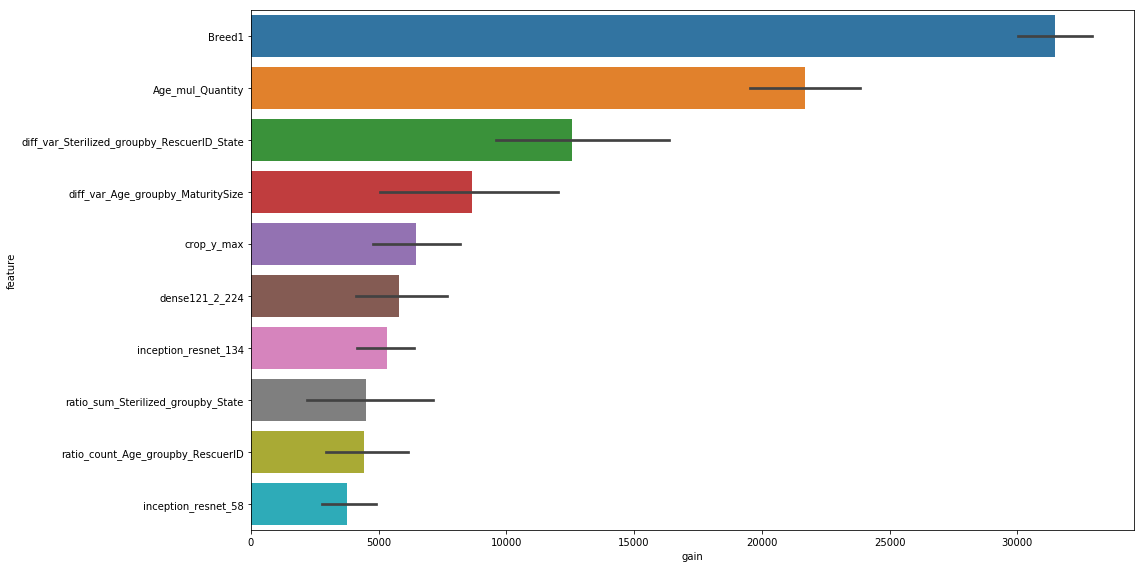

In [10]:
%%time
#n_feats =2024
#predictors = list(data.feature[:n_feats])
use_cols = pd.read_csv("importance10.csv")
use_cols["gain"] = use_cols["gain"] / use_cols["gain"].sum()
predictors = list(use_cols[use_cols.gain>0.0002].feature)
categorical_features = [c for c in categorical_features if c in predictors]
numerical_features = list(set(predictors) - set(categorical_features + [target] + remove))
#predictors = categorical_features + numerical_features

X = train.loc[:, predictors]
y =  feather.read_dataframe('../input/X_train.feather')["AdoptionSpeed"].values
rescuer_id = pd.read_csv('../input/petfinder-adoption-prediction/train/train.csv').loc[:, 'RescuerID'].iloc[:len_train]

feature_importances = pd.DataFrame()
y_pred = np.empty(len_train,)
y_test = []

#cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1337)
#for fold_id, (train_index, valid_index) in enumerate(cv.split(range(len(X)), y)):
#cv = GroupKFold(n_splits=n_splits)
#for fold_id, (train_index, valid_index) in enumerate(cv.split(range(len(X)), y=None, groups=rescuer_id)): 
cv = StratifiedGroupKFold(n_splits=n_splits)
for fold_id, (train_index, valid_index) in enumerate(cv.split(range(len(X)), y=y, groups=rescuer_id)): 
    X_train = X.loc[train_index, :]
    X_valid = X.loc[valid_index, :]
    y_train = y[train_index]
    y_valid = y[valid_index]

    y_pred_valid, importances = run_model(X_train, y_train, X_valid, y_valid,
                     categorical_features, numerical_features,
                     predictors, maxvalue_dict, fold_id)
    y_pred_valid = rankdata(y_pred_valid)/len(y_pred_valid)
    y_pred[valid_index] = y_pred_valid.ravel()

    feature_importances = pd.concat([feature_importances, importances], axis=0, sort=False)

# plot
feature_importances = plot_mean_feature_importances(
                            feature_importances, 
                            max_num=50, 
                            importance_type='gain', 
                            path='gain_feature_importances.png')

optR = OptimizedRounder()
optR.fit(y_pred, y)
coefficients = optR.coefficients()
y_pred_opt = optR.predict(y_pred, coefficients)
score = get_score(y, y_pred_opt)
print(score)

In [ ]:
100-0.4289945476630629
150-0.42939314866795686
200-0.4283107506878675

In [ ]:
importance>0-0.42532940215583626
importance>0.0002-

In [22]:
X_train.shape

(11997, 1248)

In [166]:
a = pd.DataFrame({"ID": rescuer_id, "target": y})
a.groupby("ID")["target"].agg(["mean", "count"])

,mean,count
ID,,
0007e457eb0583479bb888d54764911f,4.000000,1
0008ef529da74e9701db7eaaa4d9115a,2.500000,2
000a5830787b64da2d61b0bbceb7676d,1.500000,4
000acff3d6148772579b3e623988131b,2.000000,1
001b9870d4db6d26e2b52520dfbce249,4.000000,1
001e42763024f9d4abe31e79472b1827,2.639344,61
0024436fd0c6e89b7c94f3fdc676b6b4,2.000000,1
0035cbe4e442a7d4e622abe56254a387,2.500000,2
003902f2aeb80462168a6fea9b614f12,2.000000,2


local(16core)
特徴数-kappa(time)
---
100-0.4605709670182728(31s)
150-0.4630525352163998(38s)
200-0.4627631126511653(46s)
300-0.4614585304106906(59s)
500-0.4609961498746312(1min40s)
1000-0.4498377072144968
gain>0(1985)-0.4467023561915181(4min13s)
all(3784)-0.449078003109212(5min46s)

timeはOptimizedRounderも含む

In [17]:
len(data[data.gain>0.0002]), len(data[data.gain>0]), len(data)

(643, 1248, 2982)

In [158]:
list(data[data.gain>0.0002].feature.values)

['ratio_median_Age_groupby_Type_Breed1_Breed2',
 'ratio_median_Age_groupby_Type_Breed1',
 'BreedName_main_breed',
 'diff_var_Sterilized_groupby_RescuerID_State',
 'crop_y_max',
 'annots_score_sum_median',
 'Age_mul_Quantity',
 'img_9',
 'img_163',
 'img_224',
 'diff_mean_Fee_groupby_Type_Breed1_Breed2',
 'ratio_count_Quantity_groupby_RescuerID',
 'median_Age_groupby_RescuerID_State',
 'img_148',
 'diff_max_Quantity_groupby_State',
 'img_141',
 'img_135',
 'var_Quantity_groupby_Type_Breed1_Breed2',
 'img_49',
 'img_132',
 'diff_mean_Age_groupby_Type_Breed1',
 'img_232',
 'img_172',
 'ratio_sum_Sterilized_groupby_State',
 'gnvec155',
 'mean_Sterilized_groupby_RescuerID_State',
 'img_150',
 'img_223',
 'crop_y_mean',
 'diff_var_Age_groupby_MaturitySize',
 'diff_mean_Fee_groupby_Type_Breed1',
 'diff_var_Sterilized_groupby_RescuerID_Type',
 'mean_Fee_groupby_Type_Breed1',
 'img_46',
 'img_189',
 'img_157',
 'img_164',
 'img_56',
 'mean_Quantity_groupby_RescuerID_Type',
 'img_142',
 'dog_cat

In [162]:
data[data.feature=="nan_count"]

,feature,gain
3463,nan_count,0.000037


In [23]:
MODEL_PARAMS = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'num_leaves': 31, #no 15
    'subsample': 0.9,
    'subsample_freq': 1,
    #'colsample_bytree': 0.6,
    'max_depth': 9, #no 7
    'max_bin': 127, #no63, 255
    'reg_alpha': 0.5, #no 1.0
    'reg_lambda': 0.01, #no0.5
    'min_child_weight': 0.2, #no impact
    'min_child_samples': 10, #no 5
    'min_gain_to_split': 0.02,#no0.1, 0.01
    'min_data_in_bin': 3, #no10
    'bin_construct_sample_cnt': 5000, #no 3000, 7000
    'cat_l2': 10, #no
    'verbose': -1,
    'nthread': 16,
    'seed': 777,
}